In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical


In [ ]:
# Load data
file_path = '/content/BangloreDATA.csv'
data = pd.read_csv(file_path)


print(data.info())
print(data.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15706 entries, 0 to 15705
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   YEAR          15706 non-null  int64  
 1   MO            15706 non-null  int64  
 2   DY            15706 non-null  int64  
 3   WS2M          15706 non-null  float64
 4   T2M           15706 non-null  float64
 5   TS            15706 non-null  float64
 6   T2M_RANGE     15706 non-null  float64
 7   T2M_MAX       15706 non-null  float64
 8   T2M_MIN       15706 non-null  float64
 9   PRECTOTCORR   15706 non-null  float64
 10  RH2M          15706 non-null  float64
 11  QV2M          15706 non-null  float64
 12  PS            15706 non-null  float64
 13  WS10M         15706 non-null  float64
 14  WS50M         15706 non-null  float64
 15  WD50M         15706 non-null  float64
 16  WD10M         15706 non-null  float64
 17  RainToday     15706 non-null  int64  
 18  RainTomorrow  15706 non-nu

In [ ]:
# Correlation with RainTomorrow
correlation_matrix = data.corr()
target_correlation = correlation_matrix['RainTomorrow'].sort_values(ascending=False)


print("Top correlated features with RainTomorrow:")
print(target_correlation.head(10))

seasonal_features = ['RainToday','QV2M', 'RH2M', 'WD50M','WD10M','T2M_MIN' ]
target = 'RainTomorrow'


Top correlated features with RainTomorrow:
RainTomorrow    1.000000
RainToday       0.727364
QV2M            0.698980
RH2M            0.538817
WD50M           0.454320
WD10M           0.453894
T2M_MIN         0.450306
MO              0.348517
PRECTOTCORR     0.285438
WS2M            0.195634
Name: RainTomorrow, dtype: float64


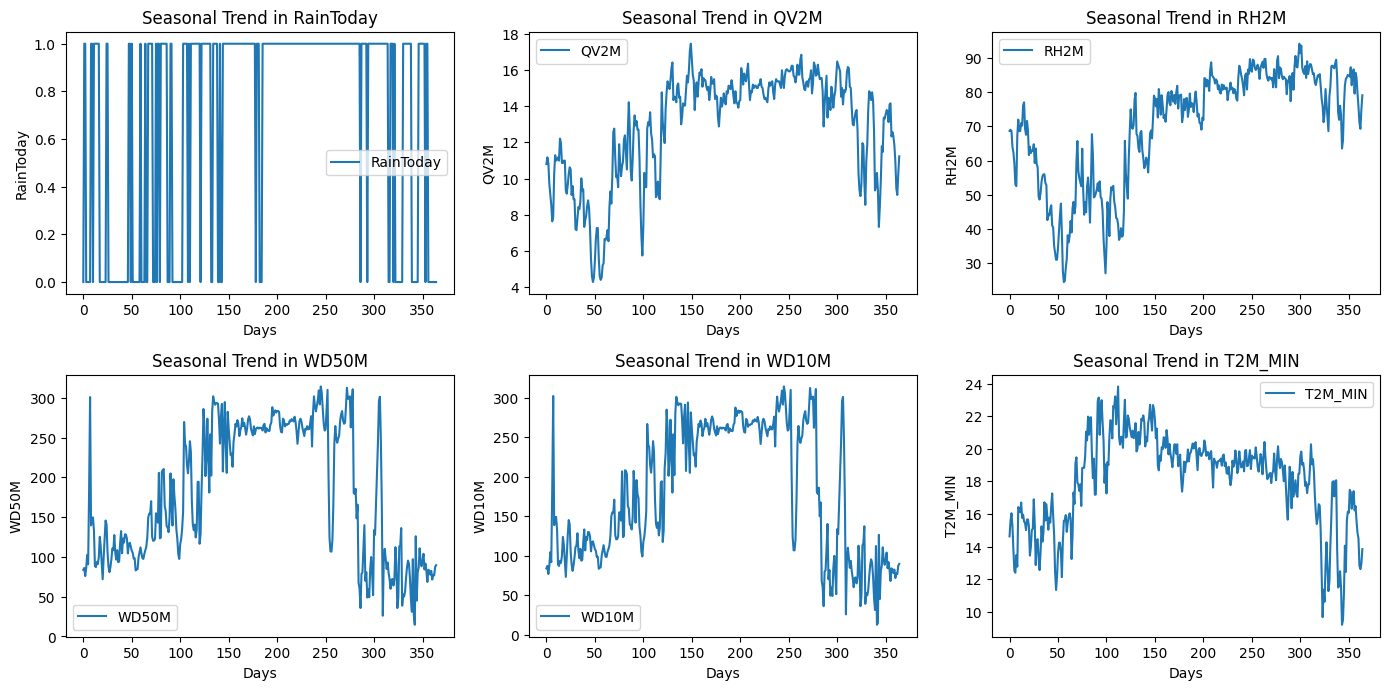

In [ ]:
plt.figure(figsize=(14, 10))
for i, feature in enumerate(seasonal_features, 1):
    plt.subplot(3, 3, i)  
    plt.plot(data[feature][:365], label=feature)  
    plt.title(f'Seasonal Trend in {feature}')
    plt.xlabel('Days')
    plt.ylabel(feature)
    plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
X = data[seasonal_features]
y = data[target]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)

scaler = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

y_train_categorical = to_categorical(y_train, num_classes=2)
y_test_categorical = to_categorical(y_test, num_classes=2)

print(f"Train shape: {X_train_scaled.shape}, Test shape: {X_test_scaled.shape}")


Train shape: (12564, 6), Test shape: (3142, 6)


In [ ]:
X = data[seasonal_features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)


X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=False)

scaler = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = scaler.fit_transform(X_train_final)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

y_train_categorical = to_categorical(y_train_final, num_classes=2)
y_val_categorical = to_categorical(y_val, num_classes=2)
y_test_categorical = to_categorical(y_test, num_classes=2)

print(f"Train shape: {X_train_scaled.shape},Validation shape:{X_val_scaled.shape}, Test shape: {X_test_scaled.shape}")

Train shape: (10051, 6),Validation shape:(2513, 6), Test shape: (3142, 6)


In [ ]:
from sklearn.utils.class_weight import compute_class_weight


y_train_labels = np.argmax(y_train_categorical, axis=1)

class_weights = compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)

class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"Class weights: {class_weight_dict}")


Class weights: {0: 1.3538523706896552, 1: 0.7927906609875375}


In [ ]:
sequence_length = 7

def create_sequences(X, y, sequence_length):
    X_seq, y_seq = [], []
    for i in range(sequence_length, len(X)):
        X_seq.append(X[i-sequence_length:i])  
        y_seq.append(y[i])  
    return np.array(X_seq), np.array(y_seq)

X_train_sequences, y_train_sequences = create_sequences(X_train_scaled, y_train_categorical, sequence_length)
X_val_sequences, y_val_sequences = create_sequences(X_val_scaled, y_val_categorical, sequence_length)
X_test_sequences, y_test_sequences = create_sequences(X_test_scaled, y_test_categorical, sequence_length)

print(f"Train shape: {X_train_sequences.shape}, Val shape: {X_val_sequences.shape}, Test shape: {X_test_sequences.shape}")


Train shape: (10044, 7, 6), Val shape: (2506, 7, 6), Test shape: (3135, 7, 6)


In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(sequence_length, len(seasonal_features))))
model.add(Dropout(0.3))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 7, 128)              │          69,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 7, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 120,674 (471.38 KB)

 Trainable params: 120,674 (471.38 KB)

 Non-trainable params: 0 (0.00 B)

None


In [20]:
# Train the model
history = model.fit(X_train_sequences, y_train_sequences, validation_data=(X_val_sequences, y_val_sequences),
                    epochs=30, batch_size=32, verbose=1 ,shuffle=False)


Epoch 1/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.6465 - loss: 0.5807 - val_accuracy: 0.8065 - val_loss: 0.4654
Epoch 2/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.8049 - loss: 0.4528 - val_accuracy: 0.8113 - val_loss: 0.4459
Epoch 3/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8157 - loss: 0.4303 - val_accuracy: 0.8160 - val_loss: 0.4364
Epoch 4/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.8209 - loss: 0.4222 - val_accuracy: 0.8160 - val_loss: 0.4351
Epoch 5/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.8264 - loss: 0.4191 - val_accuracy: 0.8160 - val_loss: 0.4329
Epoch 6/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.8264 - loss: 0.4164 - val_accuracy: 0.8156 - val_loss: 0.4325
Epoch 7/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.8268 - loss: 0.4158 - val_accuracy: 0.8125 - val_loss: 0.4345
Epoch 8/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.8291 - loss: 0.4169 - val_ac

In [ ]:
from sklearn.metrics import accuracy_score, classification_report


y_test_pred = model.predict(X_test_sequences)

y_test_pred_labels = np.argmax(y_test_pred, axis=1) 
y_test_true_labels = np.argmax(y_test_sequences, axis=1) 

# Calculate accuracy
test_accuracy = accuracy_score(y_test_true_labels, y_test_pred_labels)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Classification report for detailed metrics
print("\nClassification Report:")
print(classification_report(y_test_true_labels, y_test_pred_labels))


98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Test Accuracy: 82.26%

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.71      0.76      1245
           1       0.83      0.89      0.86      1890

    accuracy                           0.82      3135
   macro avg       0.82      0.80      0.81      3135
weighted avg       0.82      0.82      0.82      3135



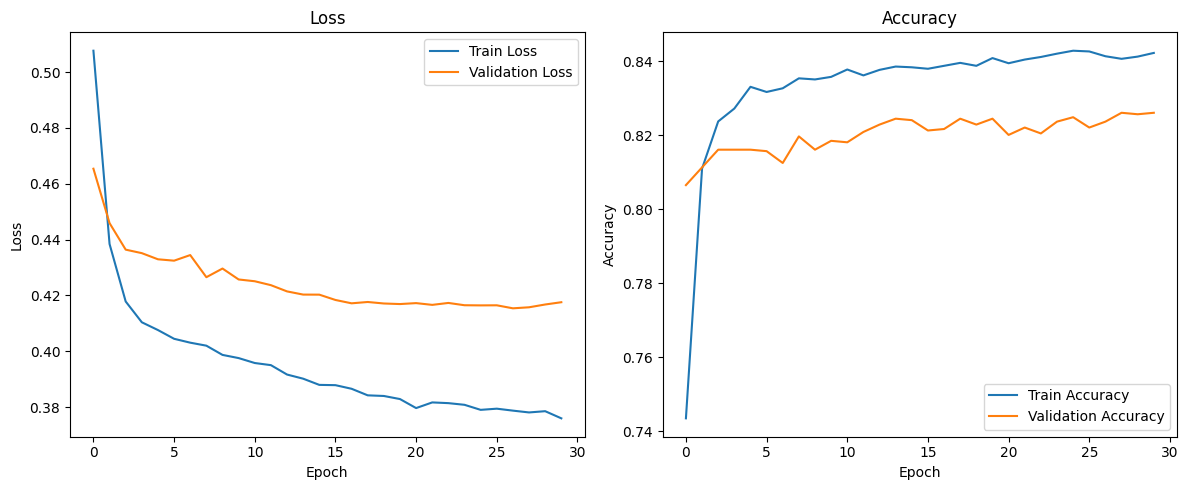

In [22]:
import matplotlib.pyplot as plt

# Plot loss and accuracy
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


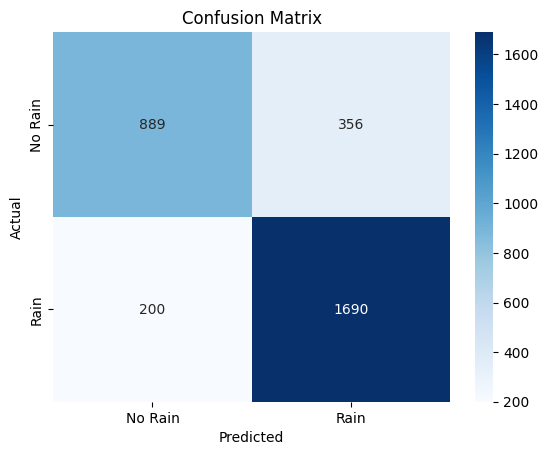

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict on test data
y_pred = model.predict(X_test_sequences)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_sequences, axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Rain', 'Rain'], yticklabels=['No Rain', 'Rain'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [24]:
import pickle
from tensorflow.keras.models import load_model

class LSTMModelWrapper:
    def __init__(self, model):
        self.model = model

    def save(self, model_path):
        """Save the LSTM model to an HDF5 file."""
        self.model.save(model_path)

    @staticmethod
    def load(model_path):
        """Load the LSTM model from an HDF5 file."""
        return load_model(model_path)

# Wrap the LSTM model
lstm_wrapper = LSTMModelWrapper(model)

# Save the wrapper and LSTM model using pickle
with open('lstm_model.pkl', 'wb') as f:
    pickle.dump(lstm_wrapper, f)
print("LSTM model saved successfully in pickle format.")


LSTM model saved successfully in pickle format.


Model 2 with class weights

In [26]:
history = model.fit(X_train_sequences, y_train_sequences, epochs=30, batch_size=32,
          validation_data=(X_test_sequences, y_test_sequences),shuffle=False,
          class_weight=class_weight_dict)


Epoch 1/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.6664 - loss: 0.6092 - val_accuracy: 0.7885 - val_loss: 0.4754
Epoch 2/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.7982 - loss: 0.4701 - val_accuracy: 0.7888 - val_loss: 0.4736
Epoch 3/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.8099 - loss: 0.4496 - val_accuracy: 0.7920 - val_loss: 0.4653
Epoch 4/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.8166 - loss: 0.4434 - val_accuracy: 0.7876 - val_loss: 0.4648
Epoch 5/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8166 - loss: 0.4394 - val_accuracy: 0.7872 - val_loss: 0.4717
Epoch 6/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.8168 - loss: 0.4377 - val_accuracy: 0.7844 - val_loss: 0.4719
Epoch 7/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8159 - loss: 0.4354 - val_accuracy: 0.7863 - val_loss: 0.4664
Epoch 8/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.8138 - loss: 0.4339 - val_ac

In [ ]:
from sklearn.metrics import accuracy_score, classification_report


y_test_pred = model.predict(X_test_sequences)


y_test_pred_labels = np.argmax(y_test_pred, axis=1)  
y_test_true_labels = np.argmax(y_test_sequences, axis=1)  


test_accuracy = accuracy_score(y_test_true_labels, y_test_pred_labels)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

print("\nClassification Report:")
print(classification_report(y_test_true_labels, y_test_pred_labels))


98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
Test Accuracy: 81.02%

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.77      0.76      1245
           1       0.84      0.84      0.84      1890

    accuracy                           0.81      3135
   macro avg       0.80      0.80      0.80      3135
weighted avg       0.81      0.81      0.81      3135



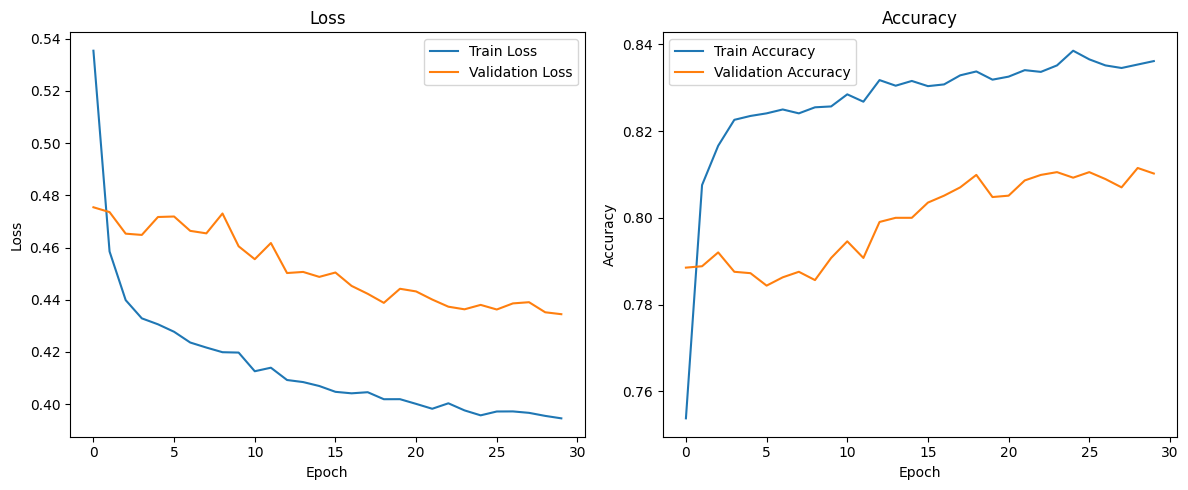

In [28]:
import matplotlib.pyplot as plt

# Plot loss and accuracy
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


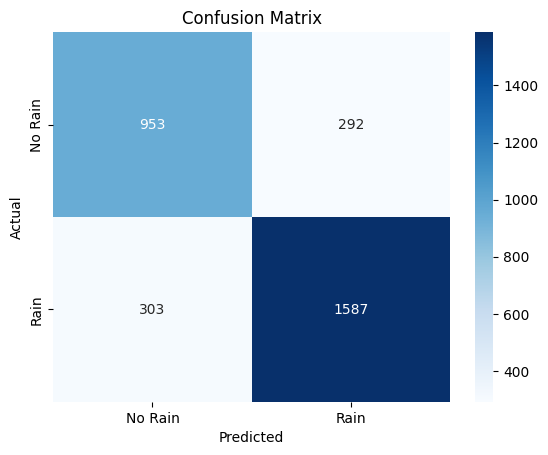

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict on test data
y_pred = model.predict(X_test_sequences)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_sequences, axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Rain', 'Rain'], yticklabels=['No Rain', 'Rain'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [30]:
import pickle
from tensorflow.keras.models import load_model

class LSTMModelWrapper:
    def __init__(self, model):
        self.model = model

    def save(self, model_path):
        """Save the LSTM model to an HDF5 file."""
        self.model.save(model_path)

    @staticmethod
    def load(model_path):
        """Load the LSTM model from an HDF5 file."""
        return load_model(model_path)

# Wrap the LSTM model
lstm_wrapper = LSTMModelWrapper(model)

# Save the wrapper and LSTM model using pickle
with open('lstm_model2.pkl', 'wb') as f:
    pickle.dump(lstm_wrapper, f)
print("LSTM model saved successfully in pickle format.")


LSTM model saved successfully in pickle format.
